# Tree-Based models

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# Some auxiliary functions for scoring and tuning
import scoring_utils, tuning_utils

#DEV
import importlib as imp
np.random.seed(99)


In [6]:
# Import the dataframe cleaned during the feature importance process.
df = pd.read_csv('../data/data_clean.csv')
target = 'Default'

In [8]:
# Add UrbanRural one-hot encoded version diretly to the dataframe. That encoding is straighforward.
df = pd.get_dummies(data=df, columns=['UrbanRural'], prefix='UrbanRural')

all_features = [feature for feature in df.columns if feature not in target]

In [12]:
# Choose features for tree based-models using count encoding and then RFE
dropped_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
features = [f for f in all_features if f not in dropped_features]
# Count encoding
count_encoded_features = ['City', 'Bank', 'State']
features_count_encoding = features + count_encoded_features

In [13]:
for feature in count_encoded_features:
    df[feature + 'Loans'] = df.groupby(feature)[feature].transform('count')
    df[feature + 'Loans'].fillna(0, inplace=True)

    features_count_encoding.remove(feature)
    features_count_encoding.append(feature+'Loans')

In [14]:
# Split for feature importance
X_train, X_, y_train, y_ = train_test_split(df[features_count_encoding], df[target], train_size=.75)

In [15]:
# Create Default Tree with all the features
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    min_samples_split=200,
    max_depth=16,
    class_weight='balanced'
    ).fit(X_train[features_count_encoding], y_train)

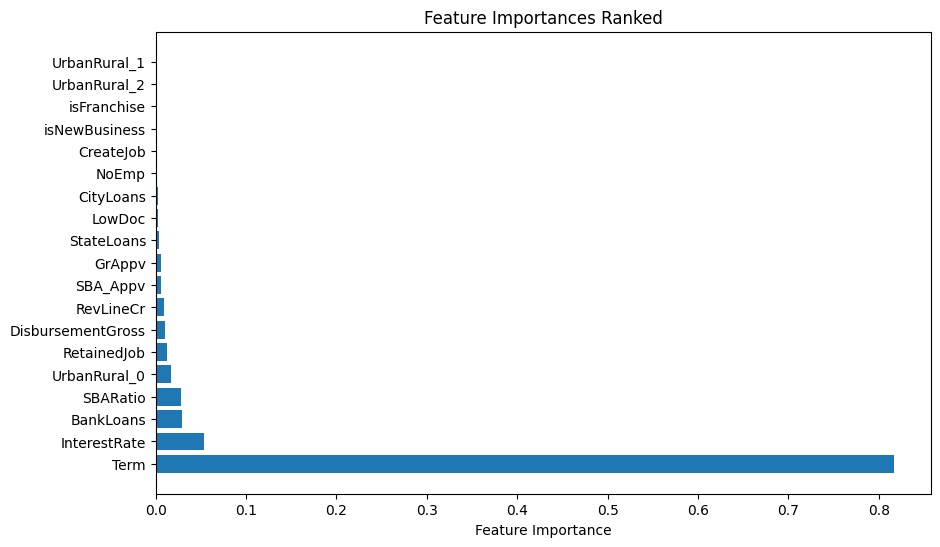

In [16]:
# Get feature importances from the trained model
importances = tree.feature_importances_

top_indices = np.argsort(importances)[::-1]

top_importances = importances[top_indices]
top_feature_names = np.array(features_count_encoding)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importances Ranked')
plt.show()

In [17]:
# I'ma peak the best 9
features_rfe = top_feature_names[:9]

In [18]:
# Prepare the data
X_total = df[features_rfe]
y_total = df[target]

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, train_size=.85)

print(f"X -- Train shape: {X_train.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, test: {y_test.shape}")


X -- Train shape: (739936, 9), test: (130578, 9)
y -- Train shape: (739936,), test: (130578,)


## Single tree
Optimized by weight.

In [19]:
weights = [.7, .75, .8, .85]

optimum_weight = 0
best_profit = 0

for weight in weights:
    model = DecisionTreeClassifier(
        max_depth=12,
        min_samples_split=200,
        class_weight={
            1: weight,
            0: (1-weight)
        }
    ).fit(X_train, y_train)
    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)
    print(f"Weight: {weight} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        optimum_weight = weight
        best_profit = profit

print(f"Optimum weight for positive target: {optimum_weight}")

Weight: 0.7 , Profit: $6,714,355,674.90
Weight: 0.75 , Profit: $6,764,873,310.60
Weight: 0.8 , Profit: $6,780,033,344.00
Weight: 0.85 , Profit: $6,620,994,176.85
Optimum weight for positive target: 0.8


In [20]:
optimum_tree = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=200,
    class_weight={
        1: optimum_weight,
        0: (1-optimum_weight)
    }
).fit(X_train, y_train)

In [21]:
best_cutoff = tuning_utils.get_cutoff(optimum_tree, X_total, y_total)
print(f"Optimum cutoff for decision tree: {best_cutoff}")

Cutoff: 0.4 , Profit: $6,710,842,320.60
Cutoff: 0.45 , Profit: $6,761,475,517.40
Cutoff: 0.5 , Profit: $6,780,030,089.30
Cutoff: 0.525 , Profit: $6,789,160,297.45
Cutoff: 0.55 , Profit: $6,796,352,482.45
Cutoff: 0.575 , Profit: $6,793,327,254.40
Cutoff: 0.6 , Profit: $6,792,510,983.70
Optimum cutoff for decision tree: 0.55


In [22]:
yhat_train = model.predict_proba(X_train)[:,1]
yhat_test = model.predict_proba(X_test)[:,1]

variance_check_tree = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Single Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Single Tree Test")
])

variance_check_tree

,Recall,Precision,ROC,F1
Single Tree Train,0.931782,0.663587,0.916971,0.775142
Single Tree Test,0.924574,0.658596,0.912933,0.769242


In [23]:
yhat_total = optimum_tree.predict_proba(X_total)[:,1]
score_tree = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Single Tree")
score_tree

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.910378,0.71175,0.917039,0.798903,"6,796,352,482.45"


## Bagging


In [24]:
from sklearn.ensemble import BaggingClassifier

#Optimize for number of estimators

estimators = [10, 20, 30, 50, 60]

best_estimator = 0
best_profit = 0

for estimator in estimators:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        n_estimators=estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Estimators: {estimator} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_estimator = estimator
        best_profit = profit

print(f"Optimum number of estimators: {best_estimator}")

Estimators: 10 , Profit: $6,851,338,685.50
Estimators: 20 , Profit: $6,871,176,810.55
Estimators: 30 , Profit: $6,868,486,208.50
Estimators: 50 , Profit: $6,872,658,156.65
Estimators: 60 , Profit: $6,871,054,521.05
Optimum number of estimators: 50


In [25]:
# Optimize for max_features for training

features = [.5, .6, .7, .8, .9, 1.0]

best_feature = 0
best_profit = 0

for feature in features:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        max_features=feature,
        n_estimators=best_estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Max features: {feature} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_feature = feature
        best_profit = profit

print(f"Optimum maximum of features: {best_feature}")

Max features: 0.5 , Profit: $6,934,057,207.65
Max features: 0.6 , Profit: $6,979,270,543.65
Max features: 0.7 , Profit: $6,989,812,453.05
Max features: 0.8 , Profit: $6,985,397,300.75
Max features: 0.9 , Profit: $6,934,458,411.50
Max features: 1.0 , Profit: $6,867,435,314.70
Optimum maximum of features: 0.7


In [26]:
# Optimize for max_samples for training

samples = [.3, .4, .5, .6, .7, .8, .9, 1.0]

best_sample = 0
best_profit = 0

for sample in samples:
    model = BaggingClassifier(
        optimum_tree,
        n_jobs=-1,
        max_features=best_feature,
        max_samples=sample,
        n_estimators=best_estimator
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Max samples: {sample} , Profit: ${profit:,.2f}")
    if profit > best_profit:
        best_sample = sample
        best_profit = profit

print(f"Optimum maximum of samples for training: {best_sample}")

Max samples: 0.3 , Profit: $6,927,880,220.00
Max samples: 0.4 , Profit: $6,932,023,889.25
Max samples: 0.5 , Profit: $6,952,503,165.70
Max samples: 0.6 , Profit: $6,958,605,416.90
Max samples: 0.7 , Profit: $6,985,209,765.55
Max samples: 0.8 , Profit: $6,975,914,819.55
Max samples: 0.9 , Profit: $6,968,712,894.35
Max samples: 1.0 , Profit: $6,932,656,288.30
Optimum maximum of samples for training: 0.7


In [27]:
optimum_bagging = BaggingClassifier(
    optimum_tree,
    max_features=best_feature,
    max_samples=best_sample,
    n_jobs=-1,
    n_estimators=best_estimator
).fit(X_train, y_train)

In [28]:
best_cutoff = tuning_utils.get_cutoff(optimum_bagging, X_total, y_total)
print(f"Optimum cutoff for bagging: {best_cutoff}")

Cutoff: 0.4 , Profit: $6,870,885,026.15
Cutoff: 0.45 , Profit: $6,951,268,179.40
Cutoff: 0.5 , Profit: $6,978,902,116.65
Cutoff: 0.525 , Profit: $6,972,616,646.55
Cutoff: 0.55 , Profit: $6,958,097,794.60
Cutoff: 0.575 , Profit: $6,928,292,774.60
Cutoff: 0.6 , Profit: $6,881,516,897.20
Optimum cutoff for bagging: 0.5


In [29]:
yhat_train = optimum_bagging.predict_proba(X_train)[:,1]
yhat_test =optimum_bagging.predict_proba(X_test)[:,1]

variance_check_bagging = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Bagging Test")
])

variance_check_bagging

,Recall,Precision,ROC,F1
Bagging Train,0.926835,0.740316,0.929749,0.823142
Bagging Test,0.921839,0.735413,0.926766,0.818140


In [30]:
yhat_total = optimum_bagging.predict_proba(X_total)[:,1]
score_bagging = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Bagging")
pd.concat([
    score_tree,
    score_bagging
])

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.910378,0.711750,0.917039,0.798903,"6,796,352,482.45"
Bagging,0.926089,0.739583,0.929303,0.822394,"6,978,902,116.65"


## RandomForest

In [31]:
from sklearn.ensemble import RandomForestClassifier
def grid_search_forest(X_train, y_train):
    # Optimize using HalvingGridSearch from sklearn

    param_grid = {
        'max_features': [.6, .7, .8, .9, 1.0]
    }

    # Cross validation in 3 folds for our grid search parameter selection.
    # It must be consistent across the folds, so the random state has to be fixed.
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

    random_forest_search = HalvingGridSearchCV(
        estimator=RandomForestClassifier(
            max_depth=50,
            min_samples_split=10,
            n_estimators=100,
            class_weight={
                1: optimum_weight,
                0: (1-optimum_weight)
            }),
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        n_jobs=-1
    )

    random_forest_search.fit(X_train, y_train)

    print(scoring_utils.get_best_kernels(random_forest_search.cv_results_))

    return random_forest_search.best_estimator_


In [32]:

# This result was found running several times a GridSearch. If you want to run the grid search
# uncomment the function call, but take into account it is very computing intensive.

# Values found before using CV
best_forest = RandomForestClassifier(
    max_depth=20,
    min_samples_split=100,
    n_estimators=100,
    class_weight={
        1: optimum_weight,
        0: (1-optimum_weight)
    },
    max_samples=1.0,
    max_features=.7,
    n_jobs=-1 #Multicore makes this a little faster
).fit(X_train, y_train)

# The following line runs the gridsearch. Can take various hours!
# best_forest = grid_search_forest(X_train, y_train) # <- Uncomment to run GridSearch

In [33]:
best_cutoff = tuning_utils.get_cutoff(best_forest, X_total, y_total)
print(f"Optimum cutoff for Random Forest: {best_feature}")

Cutoff: 0.4 , Profit: $6,994,918,446.70
Cutoff: 0.45 , Profit: $7,052,913,519.05
Cutoff: 0.5 , Profit: $7,089,809,090.40
Cutoff: 0.525 , Profit: $7,097,757,472.05
Cutoff: 0.55 , Profit: $7,091,897,762.00
Cutoff: 0.575 , Profit: $7,086,402,512.30
Cutoff: 0.6 , Profit: $7,070,920,197.30
Optimum cutoff for Random Forest: 0.7


In [34]:
yhat_train = best_forest.predict_proba(X_train)[:,1]
yhat_test = best_forest.predict_proba(X_test)[:,1]

variance_check_forest = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Random Forest Train"),
    scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Random Forest Test")
])

variance_check_forest

,Recall,Precision,ROC,F1
Random Forest Train,0.932388,0.786510,0.939984,0.853259
Random Forest Test,0.913498,0.770695,0.928761,0.836042


In [35]:
yhat_total = best_forest.predict_proba(X_total)[:,1]
score_forest = scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "Random Forest")
pd.concat([
    score_tree,
    score_bagging,
    score_forest
])

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.910378,0.711750,0.917039,0.798903,"6,796,352,482.45"
Bagging,0.926089,0.739583,0.929303,0.822394,"6,978,902,116.65"
Random Forest,0.929566,0.784147,0.938306,0.850687,"7,097,757,472.05"


# Boosting

In [36]:
np.random.seed(33)

In [37]:
X_train, X_, y_train, y_ = train_test_split(X_total, y_total, train_size=.8)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

In [38]:
import xgboost as xgb

# Tune for weight

weights = [1.5, 2, 2.5, 3, 3.5, 4, 4.25, 4.5, 4.75, 5, 5.25]

best_weight = 0
best_profit = 0

for weight in weights:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=weight
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Weight: {weight} , Profit: ${profit:,.2f}")

    if profit > best_profit:
        best_weight = weight
        best_profit = profit

print(f"Optimum weight for XGBoost: {best_weight}")


Weight: 1.5 , Profit: $6,808,560,141.15
Weight: 2 , Profit: $6,891,740,548.75
Weight: 2.5 , Profit: $6,921,172,087.50
Weight: 3 , Profit: $6,931,294,212.55
Weight: 3.5 , Profit: $6,923,093,776.10
Weight: 4 , Profit: $6,911,142,246.40
Weight: 4.25 , Profit: $6,914,910,656.85
Weight: 4.5 , Profit: $6,905,721,624.80
Weight: 4.75 , Profit: $6,895,837,046.70
Weight: 5 , Profit: $6,895,816,057.30
Weight: 5.25 , Profit: $6,873,696,038.75
Optimum weight for XGBoost: 3


In [39]:
# XGBoost hyperparams
eta_list = [ .2, .25, .275, .3, .325, .35, .375, .4]
gamma_list = [0,.25, .5, 1, 2, 3, 5, 10]
max_depth_list = [4, 5, 6, 7, 8, 10, 15, 20]
subsample_list = [.2, .5, .6, .7, .8, .9, 1.0]
subsample_cols_list = [.2, .5, .6, .7, .8, .9, 1.0]
lambda_list = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 150, 200, 500]
alpha_list = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100]
n_estimators_list = [50, 100, 200, 500, 1000, 2000]


Optimum learning rate is 0.4. CV F1: 0.8495636038760223


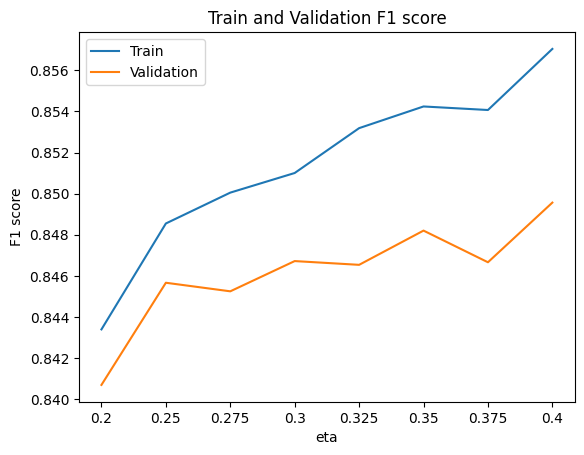

In [40]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for eta in eta_list:

    # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=eta,
    #     gamma=1
    # ).fit(X_train, y_train)

    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=eta
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_eta = eta_list[np.argmax(f1s['cv'])]
print(f"Optimum learning rate is {optimum_eta}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('eta')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(eta_list )),labels=eta_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum n_estimators is 500. CV F1: 0.8551657988489998


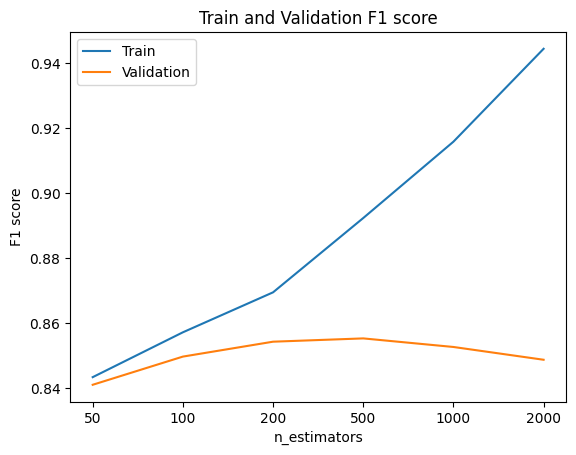

In [41]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for n_estimators in n_estimators_list:

    # # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=eta,
    #     gamma=1,
    #     n_estimators = n_estimators
    # ).fit(X_train, y_train)

    # Train a model for each one.
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=optimum_eta,
        n_estimators = n_estimators
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_estimators = n_estimators_list[np.argmax(f1s['cv'])]
print(f"Optimum n_estimators is {optimum_estimators}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('n_estimators')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum gamma is 0. CV F1: 0.8551657988489998


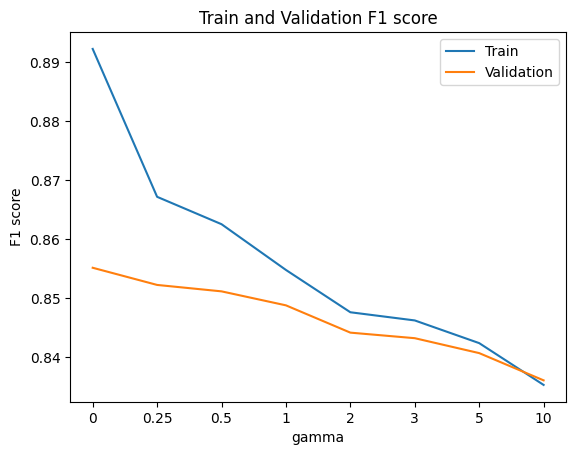

In [42]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for gamma in gamma_list:

    # # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=optimum_eta,
    #     gamma=gamma,
    #     n_estimators=optimum_estimators
    # ).fit(X_train, y_train)

    # Train a model for each one.
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=optimum_eta,
        gamma=gamma,
        n_estimators=optimum_estimators
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_gamma = gamma_list[np.argmax(f1s['cv'])]
print(f"Optimum gamma is {optimum_gamma}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('gamma')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(gamma_list )),labels=gamma_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum depth is 6. CV F1: 0.8551657988489998


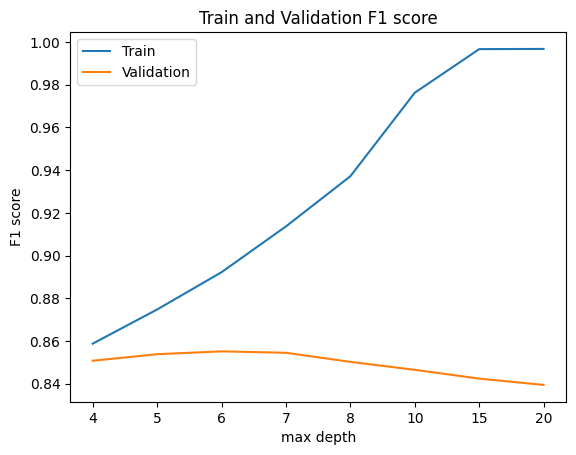

In [43]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for max_depth in max_depth_list:

    # # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=optimum_eta,
    #     n_estimators=optimum_estimators,
    #     gamma=optimum_gamma,
    #     max_depth=max_depth
    # ).fit(X_train, y_train)

    # Train a model for each one.
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=optimum_eta,
        n_estimators=optimum_estimators,
        gamma=optimum_gamma,
        max_depth=max_depth
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_depth = max_depth_list[np.argmax(f1s['cv'])]
print(f"Optimum depth is {optimum_depth}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('max depth')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum subsample is 1.0. CV F1: 0.8551657988489998


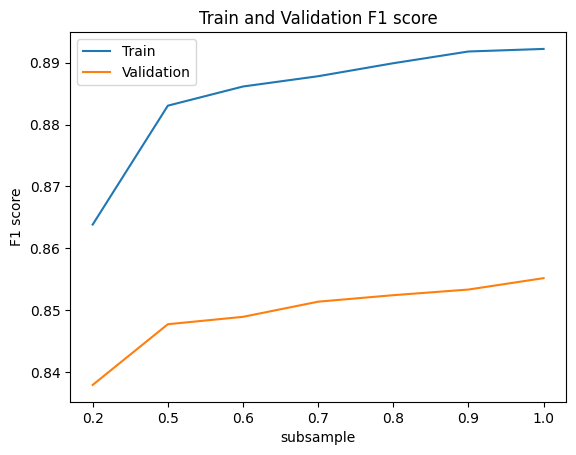

In [44]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for subsample in subsample_list:

    # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=optimum_eta,
    #     n_estimators=optimum_estimators,
    #     gamma=optimum_gamma,
    #     max_depth=optimum_depth,
    #     subsample=subsample
    # ).fit(X_train, y_train)
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=optimum_eta,
        n_estimators=optimum_estimators,
        gamma=optimum_gamma,
        max_depth=optimum_depth,
        subsample=subsample
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_subsample = subsample_list[np.argmax(f1s['cv'])]
print(f"Optimum subsample is {optimum_subsample}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('subsample')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(subsample_list )),labels=subsample_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum colsample is 1.0. CV F1: 0.8419170691926479


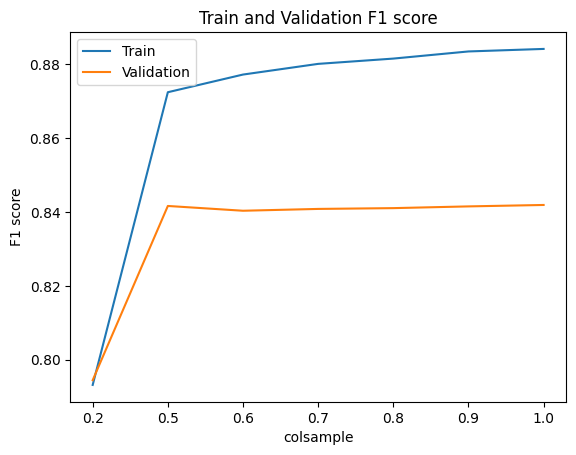

In [45]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for subsample_cols in subsample_cols_list:

    # Train a model for each one.
    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        scale_pos_weight = best_weight,
        eta=optimum_eta,
        n_estimators=optimum_estimators,
        gamma=optimum_gamma,
        max_depth=optimum_depth,
        subsample=optimum_subsample,
        colsample_bytree=subsample_cols
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_colsample = subsample_cols_list[np.argmax(f1s['cv'])]
print(f"Optimum colsample is {optimum_colsample}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('colsample')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(subsample_cols_list )),labels=subsample_cols_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

Optimum lambda is 2. CV F1: 0.8558321065425041


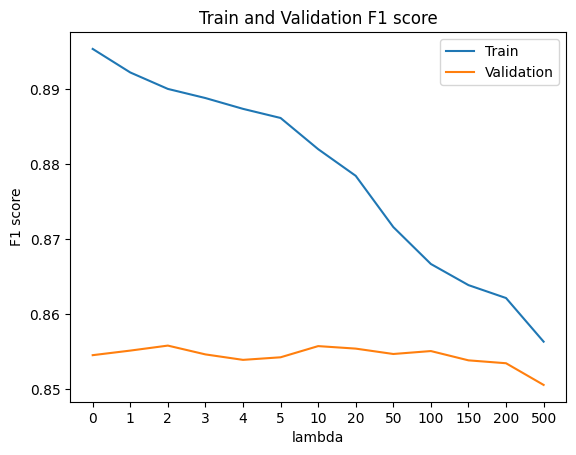

In [46]:
# F1 array for latter plotting.
f1s = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for reg_lambda in lambda_list:

    # Train a model for each one.
    # model = xgb.XGBClassifier(
    #     objective = 'binary:logistic',
    #     scale_pos_weight = best_weight,
    #     eta=optimum_eta,
    #     n_estimators=optimum_estimators,
    #     gamma=optimum_gamma,
    #     max_depth=optimum_depth,
    #     subsample=optimum_subsample,
    #     colsample_bytree=optimum_colsample,
    #     reg_lambda=reg_lambda
    # ).fit(X_train, y_train)

    model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eta=optimum_eta,
        n_estimators=optimum_estimators,
        gamma=optimum_gamma,
        max_depth=optimum_depth,
        subsample=optimum_subsample,
        colsample_bytree=optimum_colsample,
        reg_lambda=reg_lambda
    ).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    f1s["train"].append(f1_score(y_train, yhat_train))
    f1s["cv"].append(f1_score(y_cv, yhat_cv))

optimum_lambda = lambda_list[np.argmax(f1s['cv'])]
print(f"Optimum lambda is {optimum_lambda}. CV F1: {np.max(f1s['cv'])}")

plt.title('Train and Validation F1 score')
plt.xlabel('lambda')
plt.ylabel('F1 score')
plt.xticks(ticks = range(len(lambda_list )),labels=lambda_list)
plt.plot(f1s["train"])
plt.plot(f1s["cv"])
plt.legend(['Train','Validation'])

In [47]:
# best_xgb = xgb.XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight=best_weight,
#     eta=optimum_eta,
#     gamma=optimum_gamma,
#     max_depth=optimum_depth,
#     subsample=optimum_subsample,
#     colsample_bytree=optimum_colsample,
#     reg_lambda=optimum_lambda,
#     n_estimators=optimum_estimators
# ).fit(X_train, y_train)
best_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eta=optimum_eta,
    gamma=optimum_gamma,
    max_depth=optimum_depth,
    colsample_bytree=.5,
    reg_lambda=optimum_lambda,
    n_estimators=optimum_estimators
).fit(X_train, y_train)

In [48]:
yhat_train = best_xgb.predict(X_train)
yhat_test = best_xgb.predict(X_test)

variance_check_boosting = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train, "Boosting Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Boosting Test")
])

variance_check_boosting
# yhat_train = best_xgb.predict_proba(X_train)[:,1]
# yhat_test = best_xgb.predict_proba(X_test)[:,1]

# variance_check_boosting = pd.concat([
#     scoring_utils.get_metrics(y_train, yhat_train>best_cutoff, "Boosting Train"),
#     scoring_utils.get_metrics(y_test, yhat_test>best_cutoff, "Boosting Test")
# ])

# variance_check_boosting

,Recall,Precision,ROC,F1
Boosting Train,0.855879,0.903311,0.918466,0.878955
Boosting Test,0.820848,0.871738,0.897916,0.845528


In [49]:

weights = [1.5, 2, 2.5, 3, 3.5, 4, 4.25, 4.5, 4.75, 5, 5.25]

best_weight = 0
best_profit = 0

for weight in weights:
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=weight,
        eta=optimum_eta,
        gamma=optimum_gamma,
        max_depth=6,
        colsample_bytree=optimum_colsample,
        reg_lambda=optimum_lambda,
        n_estimators=optimum_estimators
    ).fit(X_train, y_train)

    yhat_total = model.predict(X_total)
    profit = scoring_utils.get_profit(X_total, y_total, yhat_total)

    print(f"Weight: {weight} , Profit: ${profit:,.2f}")

    if profit > best_profit:
        best_weight = weight
        best_profit = profit

print(f"Optimum weight for XGBoost: {best_weight}")


Weight: 1.5 , Profit: $7,114,881,406.55
Weight: 2 , Profit: $7,169,819,108.95
Weight: 2.5 , Profit: $7,191,556,820.65
Weight: 3 , Profit: $7,199,903,505.65
Weight: 3.5 , Profit: $7,199,958,914.80
Weight: 4 , Profit: $7,205,545,600.20
Weight: 4.25 , Profit: $7,194,533,175.20
Weight: 4.5 , Profit: $7,194,918,963.90
Weight: 4.75 , Profit: $7,195,729,468.65
Weight: 5 , Profit: $7,188,637,780.55
Weight: 5.25 , Profit: $7,180,650,485.10
Optimum weight for XGBoost: 4


In [50]:
best_xgb = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=best_weight,
        eta=optimum_eta,
        gamma=optimum_gamma,
        max_depth=optimum_depth,
        colsample_bytree=optimum_colsample,
        reg_lambda=optimum_lambda,
        n_estimators=optimum_estimators
).fit(X_train, y_train)

In [52]:
best_cutoff = tuning_utils.get_cutoff(best_xgb, X_total, y_total)

Cutoff: 0.4 , Profit: $7,148,466,594.40
Cutoff: 0.45 , Profit: $7,184,165,891.55
Cutoff: 0.5 , Profit: $7,205,545,600.20
Cutoff: 0.525 , Profit: $7,209,288,416.25
Cutoff: 0.55 , Profit: $7,207,228,433.85
Cutoff: 0.575 , Profit: $7,206,083,070.55
Cutoff: 0.6 , Profit: $7,199,591,064.85


In [58]:
yhat_total = best_xgb.predict_proba(X_total)[:,1]
pd.concat([
    score_tree,
    score_bagging,
    score_forest,
    scoring_utils.get_metrics_and_profit(X_total, y_total, yhat_total>best_cutoff, "XGBoost"),
    scoring_utils.get_metrics_and_profit(X_total, y_total, y_total, "Perfect Estimator")
])

,Recall,Precision,ROC,F1,"Profit, $"
Single Tree,0.910378,0.711750,0.917039,0.798903,"6,796,352,482.45"
Bagging,0.926089,0.739583,0.929303,0.822394,"6,978,902,116.65"
Random Forest,0.929566,0.784147,0.938306,0.850687,"7,097,757,472.05"
XGBoost,0.938872,0.808367,0.946406,0.868745,"7,209,288,416.25"
Perfect Estimator,1.000000,1.000000,1.000000,1.000000,"7,835,152,496.90"


In [2]:
profit_captured = scoring_utils.get_profit(X_total, y_total, yhat_total>best_cutoff)/scoring_utils.get_profit(X_total, y_total, y_total)
print(f"We captured {profit_captured*100:,.2f}% of the total profit posible")

NameError: name 'scoring_utils' is not defined

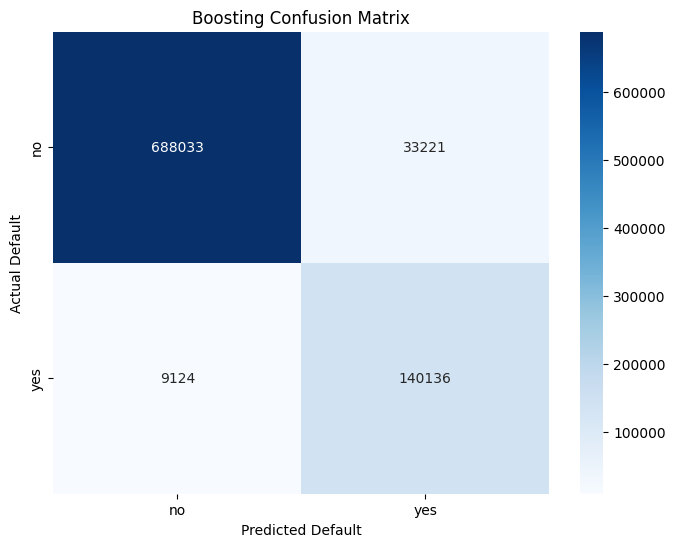

In [54]:
scoring_utils.get_confusion_matrix(y_total, yhat_total>best_cutoff, "Boosting")

In [1]:
best_xgb.save_model('best_tree.json')

NameError: name 'best_xgb' is not defined

In [56]:
data_export = df[list(features_rfe) + [target]]

In [57]:
data_export.to_csv('data_for_trees.csv', index=False)